# Experiment #2.1 - Stacking

## Overview

The purpose of this notebook is to improve the performance of the best ML models creating a Stacking classifier using all previous models together.

In [1]:
%load_ext autoreload
%autoreload 2

from utils import code
from plot_libraries import setup_graphics
from datasets import get_data

In [43]:
#Main Libraries
import os, random, re, sys, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import load

#utils
from plot_libraries import setup_graphics, dist_plot, color

#corr matrix
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from sklearn.inspection import permutation_importance
from plot_libraries import setup_graphics, plot_corr_matrix

#Data transform (pipeline)
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, LabelEncoder, OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler,RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.calibration import CalibratedClassifierCV



# Model evaluation
import scikitplot as skplt
from sklearn.metrics import make_scorer, roc_auc_score, brier_score_loss, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_predict
from evaluation import plot_learning_curve, evaluate_model, plot_confusion_matrix, evaluate_model_skopt 
from evaluation import plot_feature_permutation, plot_calibration_curve, get_cv_scores
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

# Support
import parameters as params
from model import Model, build_tuned_model
from datasets import get_data
from experiments import experiment_1, experiment_11, experiment_2, get_scorer
from sklearn.metrics import make_scorer, roc_auc_score, brier_score_loss, classification_report, confusion_matrix

#setup
warnings.filterwarnings("ignore")
pd.options.display.max_columns = None
sns.set()
%matplotlib inline
setup_graphics()

In [3]:
X, y = get_data('../data/trainDF.csv')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=20) #stratify=y,

### Loading Pipelines

In [4]:
pipeline2 = experiment_2.get_full_pipeline()
ps = pipeline2.fit_transform(X_train).shape
print('Instances: {:,}, Features: {}'.format(ps[0], ps[1]))

Instances: 1,479, Features: 12


In [5]:
pipeline1 = experiment_11.get_full_pipeline()
ps = pipeline1.fit_transform(X_train).shape
print('Instances: {:,}, Features: {}'.format(ps[0], ps[1]))

Instances: 1,479, Features: 61


In [6]:
#setup
scorer = make_scorer(roc_auc_score)
results, res_cv, res_calibrated, n_iter = list(), dict(), dict(), 100

## ML Models

Stacking Structure:

Level-1:

* LogisticRegression(pipeline1 & RandomizedSearchCV=5, n_iter=100)
* SGDClassifier(pipeline1 & RandomizedSearchCV=5, n_iter=100)
* XGBClassifier(pipeline2 & BayesSearchCV=5, n_iter=100)
* LGBMClassifier(pipeline2 & BayesSearchCV=5, n_iter=100)
* KNeighborsClassifier(pipeline1 & RandomizedSearchCV=5, n_iter=100)

**Logistic Regression**
* LogisticRegression(pipeline1 & RandomizedSearchCV=5, n_iter=100)

In [7]:
from sklearn.linear_model import LogisticRegression
import bayes_grid_models as bgrid
import param_grid_models as pgrid

result = evaluate_model(X_train, y_train, 'lr', 
                        LogisticRegression(), 
                        pgrid.lr_param_grid, 
                        scorer, n_iter=n_iter, 
                        cv_folds=5, pipeline=pipeline1)
results.append(result)
res_cv[result[1]] = get_cv_scores(result[0])

==> Starting 5-fold cross validation for lr model, 1479 examples
Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:   12.8s


==> Elapsed seconds: 18.660
Best lr model: LogisticRegression(C=100.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
Best lr score (val): 0.646


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   18.6s finished


**SGD Classifier**

* SGDClassifier(pipeline1 & RandomizedSearchCV=5, n_iter=100)

In [8]:
from sklearn.linear_model import SGDClassifier

result = evaluate_model(X_train, y_train, 'sgd', 
                        SGDClassifier(), 
                        pgrid.sgd_param_grid, 
                        scorer, n_iter=n_iter, 
                        cv_folds=5, pipeline=pipeline1)

results.append(result)
res_cv[result[1]] = get_cv_scores(result[0])

==> Starting 5-fold cross validation for sgd model, 1479 examples
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 300 tasks      | elapsed:    9.0s


==> Elapsed seconds: 14.781
Best sgd model: SGDClassifier(alpha=0.001, average=False, class_weight='balanced',
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=-1, penalty='l1', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
Best sgd score (val): 0.635


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   14.7s finished


**XGBoost**

* XGBClassifier(pipeline2 & BayesSearchCV=5, n_iter=100)

In [9]:
from xgboost import XGBClassifier

result = evaluate_model_skopt(X_train, y_train, 'xgb', 
                        XGBClassifier(), 
                        bgrid.xgb_param_grid, 
                        scorer, n_iter=n_iter, 
                        cv_folds=5, pipeline=pipeline2)

results.append(result)
res_cv[result[1]] = get_cv_scores(result[0])

==> Starting 5-fold cross validation for xgb model, 1479 examples
==> Elapsed seconds: 879.237
Best xgb model: XGBClassifier(base_score=0.5, booster=None,
              colsample_bylevel=0.8159980140710431, colsample_bynode=1,
              colsample_bytree=1.0, gamma=0.514848966757468, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.18661335632389411, max_delta_step=0, max_depth=21,
              min_child_weight=8, missing=nan, monotone_constraints=None,
              n_estimators=264, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0,
              reg_alpha=0.04540470406473515, reg_lambda=1.0,
              scale_pos_weight=5314, subsample=0.9131512038626207,
              tree_method=None, validate_parameters=False, verbosity=None)
Best xgb score (val): 0.736


**Light GBM**

* LGBMClassifier(pipeline2 & BayesSearchCV=5, n_iter=100)

In [10]:
from lightgbm import LGBMClassifier

result = evaluate_model_skopt(X_train, y_train, 'lgbm',
                        LGBMClassifier(),
                        bgrid.lgbm_param_grid, 
                        scorer, n_iter=n_iter, 
                        cv_folds=5, pipeline=pipeline2)

results.append(result)
res_cv[result[1]] = get_cv_scores(result[0])

==> Starting 5-fold cross validation for lgbm model, 1479 examples
==> Elapsed seconds: 694.925
Best lgbm model: LGBMClassifier(boosting_type='dart', class_weight=None, colsample_bytree=1.0,
               importance_type='split', is_unbalance=True,
               learning_rate=0.08389593732655422, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=9, objective=None,
               random_state=None, reg_alpha=1.0, reg_lambda=0.001, silent=True,
               subsample=0.5, subsample_for_bin=191046, subsample_freq=0)
Best lgbm score (val): 0.725


**K-Nearest Neighboors**

* KNeighborsClassifier(pipeline1 & RandomizedSearchCV=5, n_iter=100)

In [11]:
from sklearn.neighbors import KNeighborsClassifier

result = evaluate_model(X_train, y_train, 'knn', 
                        KNeighborsClassifier(), 
                        pgrid.knn_param_grid, 
                        scorer, n_iter=n_iter, 
                        cv_folds=5, pipeline=pipeline1)

results.append(result)
res_cv[result[1]] = get_cv_scores(result[0])

==> Starting 5-fold cross validation for knn model, 1479 examples
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   40.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.0min


==> Elapsed seconds: 69.781
Best knn model: KNeighborsClassifier(algorithm='auto', leaf_size=14, metric='manhattan',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=3,
                     weights='distance')
Best knn score (val): 0.556


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.2min finished


#### Comparing results (validation scores)

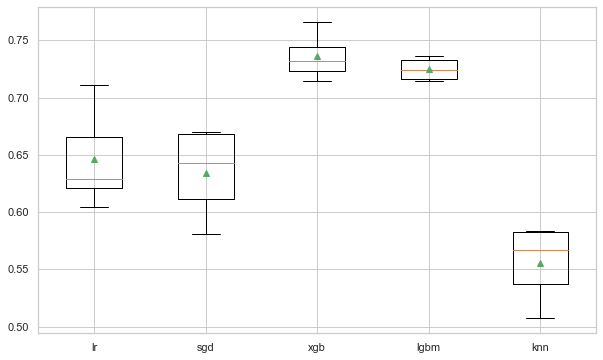

In [12]:
_ = plt.boxplot(res_cv.values(), labels=res_cv.keys(), showmeans=True)

In [26]:
def get_full_pipeline(results, name): 
    model = list(filter(lambda x: x[1] == name, results))[0][0]
    PATH = '../models_pkl/experiment-2.1-stacking_80_'+name+'.pkl'
    model.save(PATH)
    model_pipeline = model.get_model_pipeline()
    return model_pipeline

level1_clf = []
clf_names = ['lr', 'sgd', 'xgb', 'lgbm', 'knn', 'StackingClassifier']
for name in clf_names[:-1]:
    level1_clf.append(get_full_pipeline(results, name))

--------------
--------------

### Stacking

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier

In [8]:
models_l1, level1_clf = {}, []
clf_names = ['lr', 'sgd', 'xgb', 'lgbm', 'knn', 'StackingClassifier']

for name in clf_names[:-1]:
    PATH = '../models_pkl/experiment-2.1-stacking_80_'+name+'.pkl'
    model = Model.load(PATH)
    model_pipeline = model.get_model_pipeline()
    level1_clf.append(model_pipeline)

In [9]:
from mlxtend.classifier import StackingCVClassifier
from sklearn import model_selection

model_l2 = LogisticRegression()
stack_clf = level1_clf.copy()
sclf1 = StackingCVClassifier(classifiers=level1_clf, 
                            meta_classifier=model_l2,
                            store_train_meta_features=True,
                            random_state=20, cv=5,
                            verbose=0, use_probas=False)


stack_clf.append(sclf1)                                      
print('5-fold cross validation:\n')
for clf, label in zip(stack_clf, clf_names):
    scores = model_selection.cross_val_score(clf, X_train, y_train, cv=5, scoring=scorer)
    print("AUC: %0.3f (+/- %0.2f) [%s]"  % (scores.mean(), scores.std(), label))

5-fold cross validation:

AUC: 0.643 (+/- 0.03) [lr]
AUC: 0.638 (+/- 0.04) [sgd]
AUC: 0.704 (+/- 0.02) [xgb]
AUC: 0.715 (+/- 0.02) [lgbm]
AUC: 0.533 (+/- 0.02) [knn]
AUC: 0.500 (+/- 0.00) [StackingClassifier]


              precision    recall  f1-score   support

           0       0.87      0.94      0.90       307
           1       0.50      0.29      0.36        63

    accuracy                           0.83       370
   macro avg       0.68      0.61      0.63       370
weighted avg       0.80      0.83      0.81       370



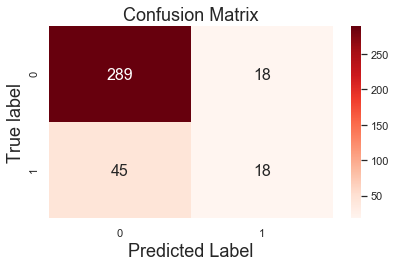

In [12]:
sclf1.fit(X_train, y_train)
l2 = sclf1.predict(X_test)  
plot_confusion_matrix(y_test, l2) 

Get L2-Predictions

#### Corr Matrix L2-Features

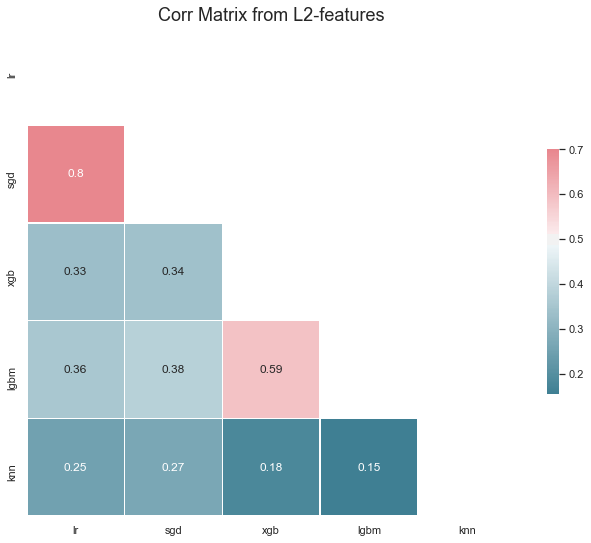

In [11]:
l2_df = pd.DataFrame(sclf1.train_meta_features_, columns=clf_names[:-1])
plot_corr_matrix(l2_df)

--------------
-------------

In [12]:
%%time
from sklearn import model_selection
from sklearn.model_selection import RandomizedSearchCV


params = {
  'meta_classifier__C': np.logspace(-3, 2, 6), 
  'meta_classifier__max_iter': [10, 50, 100, 200, 500],
  'meta_classifier__penalty':  ['l1', 'l2'], 
  'meta_classifier__solver': ['liblinear'],
  'meta_classifier__tol': [0.0001, 0.001 ,0.01],
  'meta_classifier__class_weight': [None, {0:1,1:1}, {0:1,1:10}, {0:1,1:100}, 'balanced']
}


#0.747
grid = RandomizedSearchCV(estimator=sclf1, 
                    param_distributions=params, 
                    scoring=scorer,
                    cv=5,
                    n_iter=50,
                    refit=True,
                    verbose=0)

grid.fit(X_train, y_train)

print('Best parameters: %s' % grid.best_params_)
print('AUC: %.3f' % grid.best_score_)

Best parameters: {'meta_classifier__tol': 0.0001, 'meta_classifier__solver': 'liblinear', 'meta_classifier__penalty': 'l2', 'meta_classifier__max_iter': 100, 'meta_classifier__class_weight': 'balanced', 'meta_classifier__C': 10.0}
AUC: 0.712
CPU times: user 1h 9min 52s, sys: 4min 55s, total: 1h 14min 47s
Wall time: 28min 48s


In [13]:
%%time

best_params ={'meta_classifier__tol': 0.0001,
              'meta_classifier__solver': 'liblinear',
              'meta_classifier__penalty': 'l2',
              'meta_classifier__max_iter': 100,
              'meta_classifier__class_weight': 'balanced',
              'meta_classifier__C': 10.0}


best_model = list(best_params.values())
#best_model = list(grid.best_params_.values())
model_l2 = LogisticRegression(tol=best_model[0],
                              solver=best_model[1],
                              penalty=best_model[2],
                              max_iter =best_model[3],
                              class_weight=best_model[4],
                              C=best_model[5])


stack_clf = level1_clf.copy()
sclf2 = StackingCVClassifier(classifiers=level1_clf, 
                            meta_classifier=model_l2,
                            store_train_meta_features=True,
                            random_state=20, cv=5,
                            verbose=0, use_probas=False)


stack_clf.append(sclf2)                                      
print('5-fold cross validation:\n')
scores = model_selection.cross_val_score(sclf2, X_train, y_train, cv=5, scoring=scorer)
print("AUC: %0.3f (+/- %0.2f) [%s]"  % (scores.mean(), scores.std(), clf_names[-1]))

5-fold cross validation:

AUC: 0.709 (+/- 0.02) [StackingClassifier]
CPU times: user 1min 20s, sys: 1.4 s, total: 1min 22s
Wall time: 23.4 s


              precision    recall  f1-score   support

           0       0.91      0.77      0.83       307
           1       0.36      0.63      0.46        63

    accuracy                           0.75       370
   macro avg       0.64      0.70      0.65       370
weighted avg       0.82      0.75      0.77       370



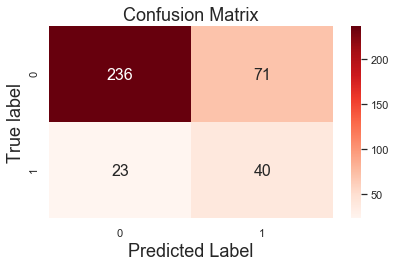

In [14]:
sclf2.fit(X_train, y_train)
preds_l2 = sclf2.predict(X_test); setup_graphics()  
plot_confusion_matrix(y_test, preds_l2) 

In [25]:
#preds_l2 = sclf2.predict(X); setup_graphics()  
#plot_confusion_matrix(y, preds_l2) 

In [32]:
from joblib import dump, load
dump(sclf2, '../models_pkl/experiment-2.1-stacking_80_L2.pkl')

['../models_pkl/experiment-2.1-stacking_80_L2.pkl']

### Ensemble Voting

In [17]:
from mlxtend.classifier import EnsembleVoteClassifier


eclf_hard = EnsembleVoteClassifier(clfs=level1_clf, voting='hard')
eclf_soft = EnsembleVoteClassifier(clfs=level1_clf, voting='soft')
eclf_names = clf_names[:-1] + ['eclf_hard' , 'eclf_soft']


voting_clf = level1_clf.copy()
voting_clf.append(eclf_hard) 
voting_clf.append(eclf_soft) 

print('5-fold cross validation:\n')
for clf, label in zip(voting_clf, eclf_names):
    scores = model_selection.cross_val_score(clf, X_train, y_train, cv=5, scoring=scorer)
    print("AUC: %0.3f (+/- %0.2f) [%s]"  % (scores.mean(), scores.std(), label))

5-fold cross validation:

AUC: 0.643 (+/- 0.03) [lr]
AUC: 0.650 (+/- 0.04) [sgd]
AUC: 0.704 (+/- 0.02) [xgb]
AUC: 0.715 (+/- 0.02) [lgbm]
AUC: 0.533 (+/- 0.02) [knn]
AUC: 0.685 (+/- 0.03) [eclf_hard]
AUC: 0.693 (+/- 0.03) [eclf_soft]


Soft Voting

              precision    recall  f1-score   support

           0       0.89      0.82      0.85       307
           1       0.36      0.49      0.42        63

    accuracy                           0.76       370
   macro avg       0.62      0.66      0.63       370
weighted avg       0.80      0.76      0.78       370



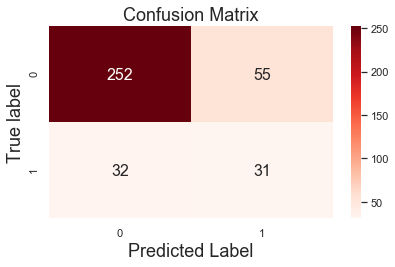

In [18]:
eclf_soft.fit(X_train, y_train)
preds_l2 = eclf_soft.predict(X_test);  
plot_confusion_matrix(y_test, preds_l2)

In [24]:
#preds_l2 = eclf_soft.predict(X); setup_graphics()  
#plot_confusion_matrix(y, preds_l2) 

Hard Voting

              precision    recall  f1-score   support

           0       0.90      0.78      0.84       307
           1       0.36      0.60      0.45        63

    accuracy                           0.75       370
   macro avg       0.63      0.69      0.64       370
weighted avg       0.81      0.75      0.77       370



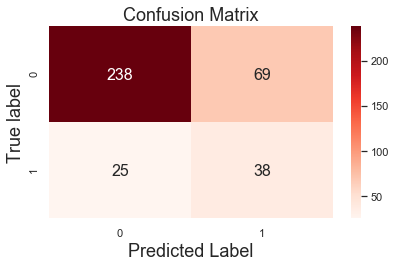

In [21]:
eclf_hard.fit(X_train, y_train)
preds_l2 = eclf_hard.predict(X_test);  
plot_confusion_matrix(y_test, preds_l2)

In [23]:
#preds_l2 = eclf_hard.predict(X); setup_graphics()  
#plot_confusion_matrix(y, preds_l2) 

--------------
-------------

### Analyzing best model

In [35]:
from joblib import load
model_l2 = load('../models_pkl/experiment-2.1-stacking_80_L2.pkl')

The learning curve may suggest some overfiting, however the linear models which shows a funnel shape curve, had very poor results on test set.

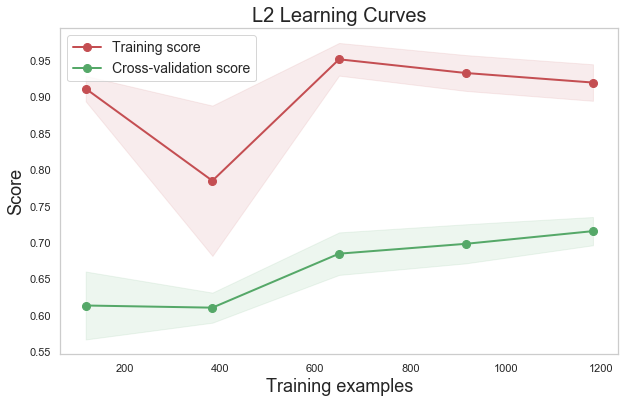

In [36]:
plot_learning_curve(model_l2, 
                    'L2 Learning Curves',
                    X_train, y_train,
                    cv=5, scoring=scorer)

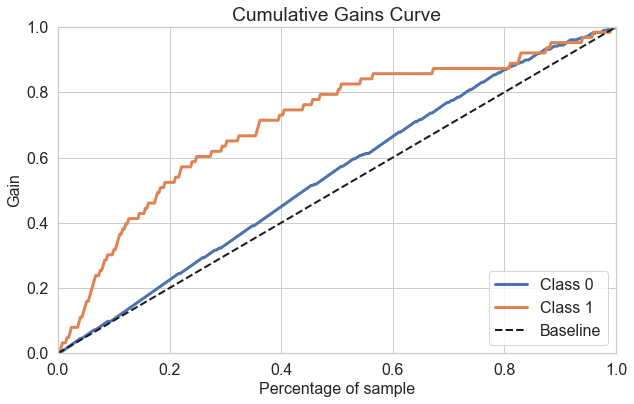

In [37]:
#preds, probs = model.predict_calibrated(X_test, X_train, y_train)
preds = model_l2.predict(X_test)
probs = model_l2.predict_proba(X_test)
_ = skplt.metrics.plot_cumulative_gain(y_test, probs)

              precision    recall  f1-score   support

           0       0.91      0.77      0.83       307
           1       0.36      0.63      0.46        63

    accuracy                           0.75       370
   macro avg       0.64      0.70      0.65       370
weighted avg       0.82      0.75      0.77       370



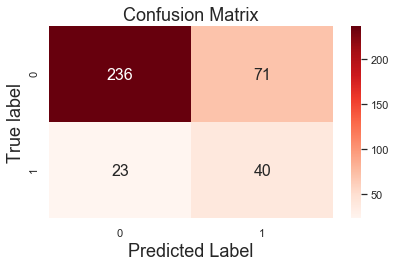

In [38]:
plot_confusion_matrix(y_test, preds)

#### Feature Importance

> The new pipeline, which removed leaky and high corr features, presented feature importances much more aligned with our business expectations with `Employees` and `Account_ICP_Score`, among them.

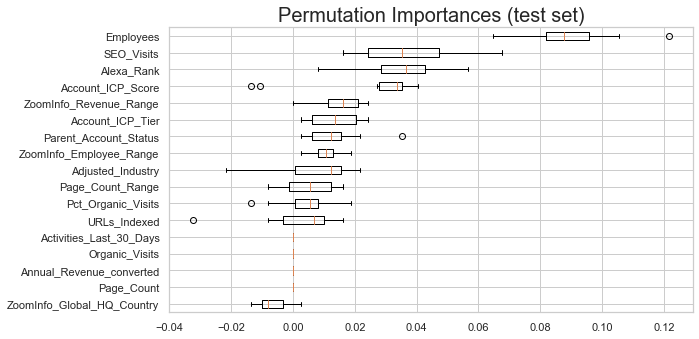

In [39]:
result = permutation_importance(model_l2, X_test, y_test, n_repeats=10, random_state=20, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(10,5))
ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

-------------
-------------

### Financial Impact of the Best Model

In [40]:
n_instances = len(X)
p_instances = y.sum() / len(y)
p_targeted = 0.1
n_targeted = int(n_instances*p_targeted)
n_targeted_test = int(len(X_test) * p_targeted)

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        17
         1.0       0.54      1.00      0.70        20

    accuracy                           0.54        37
   macro avg       0.27      0.50      0.35        37
weighted avg       0.29      0.54      0.38        37



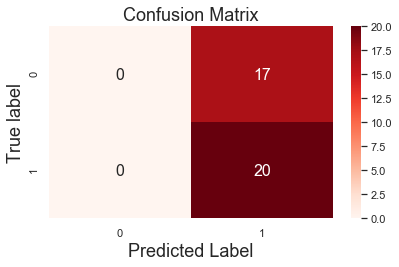

In [41]:
# Create a dataframe of probabilities and actual / predicted outcomes
probs_df = pd.DataFrame(np.hstack([probs, y_test.values.reshape(-1,1), preds.reshape(-1,1)]), 
                        columns=['p_no', 'p_yes', 'actual', 'predicted'])


# Sort customers by the probability that they will convert
model_targets = probs_df.sort_values('p_yes', ascending=False)

# Take the top 10%
model_targets = model_targets.head(n_targeted_test)

# Calculate precision matrix
plot_confusion_matrix(model_targets.actual, model_targets.predicted)

Picking the top 10% fo our model prediction, the precision went down 6% (~84%) from exp1.0.

In [58]:
# Setup costs and benefits
avg_revenue = params.AVG_REVENUE
avg_cost = params.AVG_COST

# Calculate financial outcomes
random_profit = experiment_1.get_model_profit(X_test, y_test, n_targeted_test, avg_revenue, avg_cost, experiment_1.random_model_predictions)
baseline_profit = experiment_1.get_model_profit(X_test, y_test, n_targeted_test, avg_revenue, avg_cost, experiment_1.baseline_model_predictions)
model_profit = experiment_1.get_model_profit(X_test, y_test, n_targeted_test, avg_revenue, avg_cost, preds=model_targets.actual)

print('Number of customers targeted: {:,}/{:,}'.format(len(model_targets), len(X_test)))
print('Conversion rate of model policy: {:.2f}%'.format(model_targets.actual.sum() / n_targeted_test*100.))#len(y_test)*100.))
print('Expected profit of model policy: ${:,}'.format(model_profit))
print('Lift over random: {:.1f} or ${:,}'.format(model_profit / random_profit, model_profit - random_profit))
print('Lift over baseline: {:.1f} or ${:,}'.format(model_profit / baseline_profit, model_profit - baseline_profit))

Number of customers targeted: 37/370
Conversion rate of model policy: 54.05%
Expected profit of model policy: $19,630
Lift over random: 2.3 or $11,000
Lift over baseline: 3.0 or $13,000
